## **Practical session (graded session), Computational Imaging**
Objective: implement and evaluate continuous (variational) and discrete (MRF) formulations for image denoising

# Part I: Heat equation
Derive and implement the diffusion equation associated with the minimization of the regularisation energy $\int_\Omega \|\nabla u(p)\|^2dp$.

Load an image using skimage module. Test images are available at: https://homepages.cae.wisc.edu/~ece533/images/

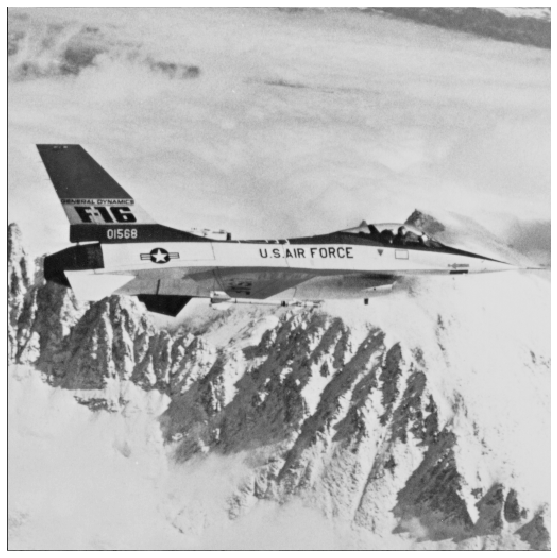

In [35]:
## load an image
import skimage
from skimage.io import imread
import matplotlib.pyplot as plt

import numpy as np
from scipy.ndimage.filters import convolve
from skimage.color import rgb2gray
from skimage.exposure import histogram


u = imread('airplane.png', )
u= rgb2gray(u)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(u,vmin=0,vmax=1, cmap='gray')
plt.show()

Apply a N-step diffusion process to the loaded image based on the heat equation
Code this N-step diffusion process as a callable function using as input parameters, the image u, the numer of iterations N and a scalar parameter $\lambda$

In [2]:
def computeHeatDiffusion(u,N,Lambda):
    uf = u
    pX= np.array([[0,1,0],[1,-4,1],[0,1,0]])
    for i in range(N):
         uf= uf + 2*Lambda*(convolve(uf, pX, mode='constant', cval=0.0))
    return uf

Visualize the result of the diffusion on an image and highlight through an approriate visualization and/or evaluation metrics the quality of the output image.

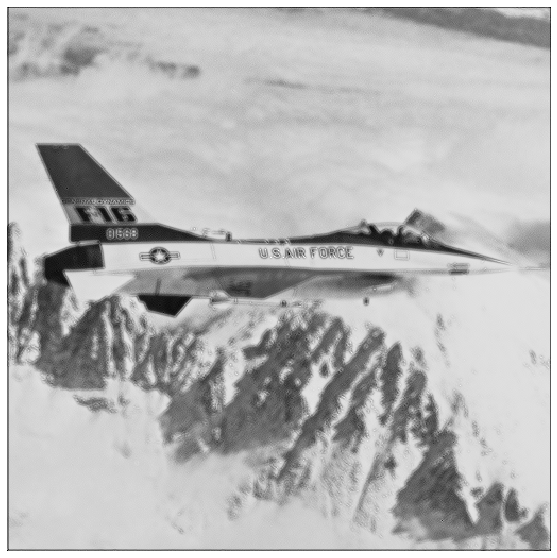

In [3]:
u_lap = computeHeatDiffusion(u,1,0.3)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(u_lap,vmin=0,vmax=1,cmap='gray')
plt.show()

# Part II: Heat equation for image denoising
Derive and implement the diffusion equation associated with image denoising according to the following cost function $\min_u \int_\Omega \| u(p)-v(p)\|^2dp+\alpha \int_\Omega \|\nabla u(p)\|^2dp$, where $v$ is a noisy image.

Load an image and generate a noisy image using an additive Gaussian noise. You can use function np.random.normal() to generate the noise.

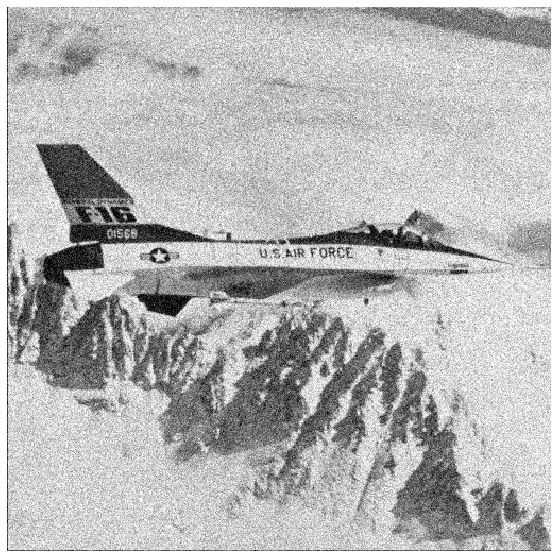

In [4]:
u_noise = u + np.random.normal(loc=0.0, scale=0.1,size = u.shape)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(u_noise,vmin=0,vmax=1,cmap='gray')
plt.show()

Implement a diffusion equation to solve the above minimization through a function denoisingHeatDiffusion(v,N,alpha) with v the noisy image, N the number of iterations of the diffusion, $\alpha$ the weighing factor of the regularization term and $\lambda$ the gradient step

In [5]:
def denoisingHeatDiffusion(v,N,alpha,Lambda):
    v = v 
    u_k = v
    pX= np.array([[0,1,0],[1,-4,1],[0,1,0]])
    for i in range(N):
        u_k_1= u_k - 2*Lambda*((u_k - v)-alpha*convolve(u_k, pX, mode='constant', cval=0.0))
        u_k = u_k_1
    uf = u_k
    return uf

Run denoising experiments and evaluate the quality of the denoising process w.r.t. the main parameters of the denoising scheme



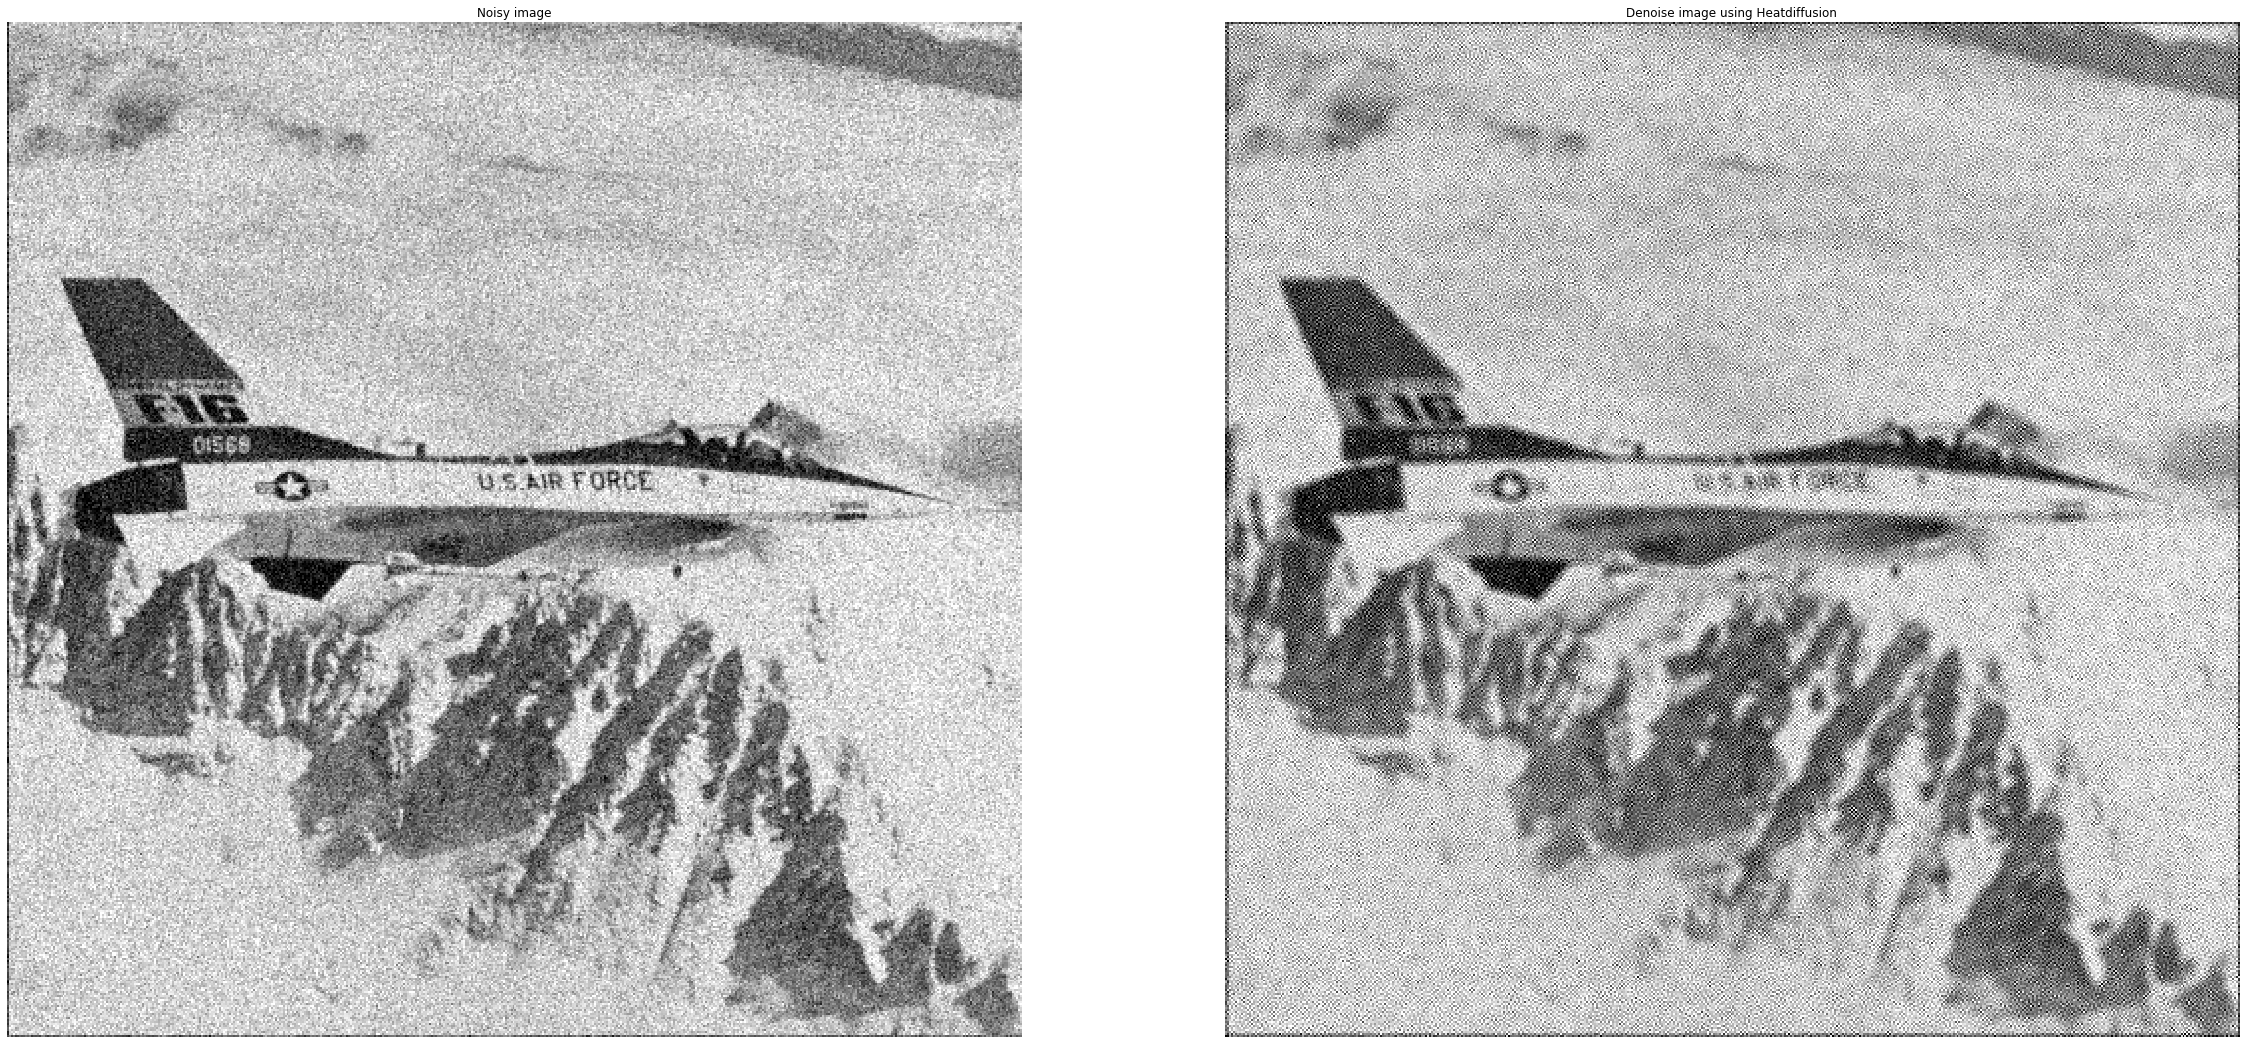

In [6]:
u_denoise = denoisingHeatDiffusion(u_noise, 1, 0.3, 1)  # 100, 4, 0.01  
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('Noisy image')
plt.axis('off')
plt.imshow(u_noise,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise image using Heatdiffusion")
plt.axis('off')
plt.imshow(u_denoise,vmin=0,vmax=1, cmap='gray')
plt.show()

In [7]:
moudle = np.zeros((512, 512))
moudle[206:306, 206:306] = 1 
denoise_moudle = denoisingHeatDiffusion(moudle, 1, 0.3, 1)

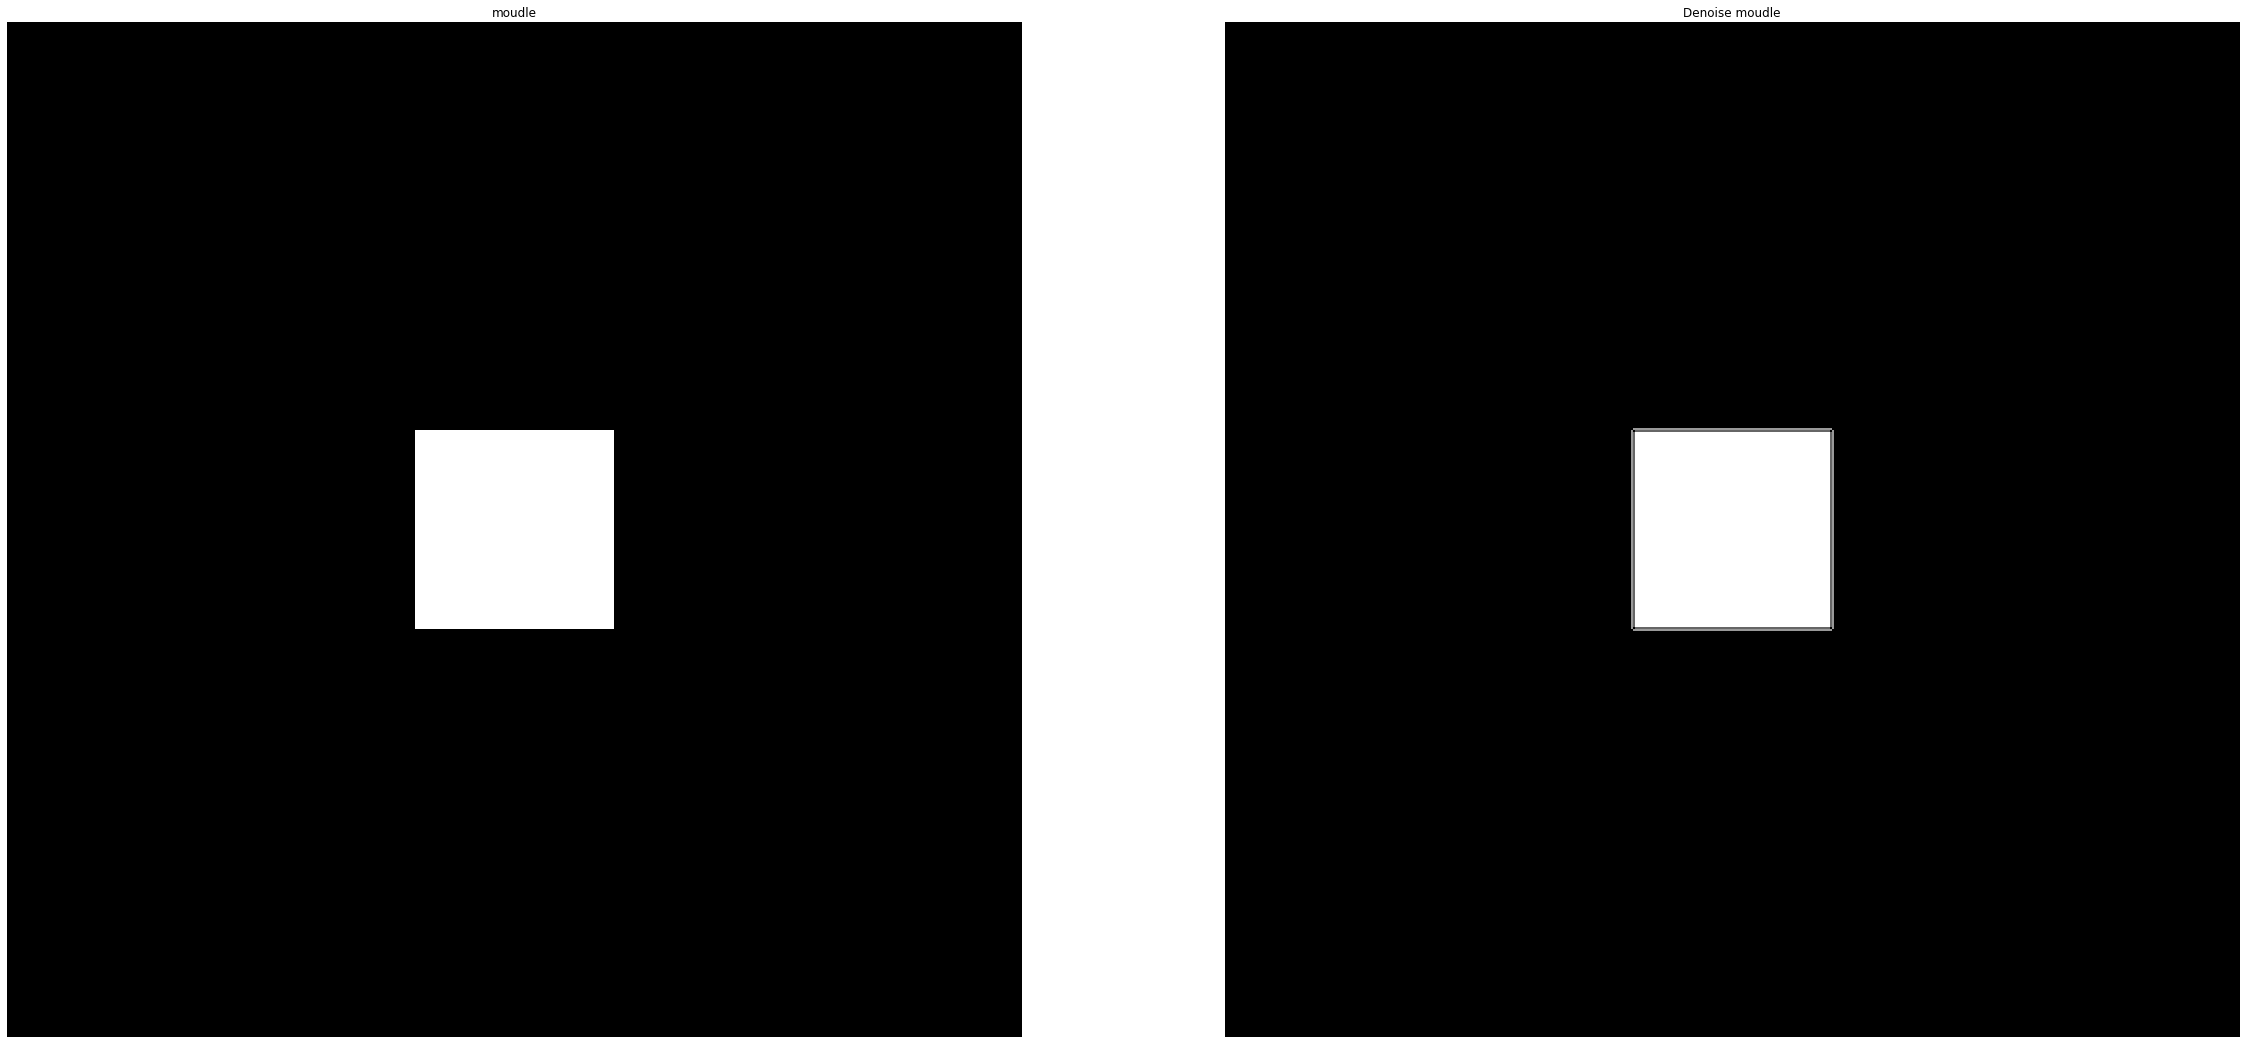

In [8]:
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('moudle')
plt.axis('off')
plt.imshow(moudle,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise moudle")
plt.axis('off')
plt.imshow(denoise_moudle,vmin=0,vmax=1, cmap='gray')
plt.show()

Illustrate through one or two examples the key properties of the diffusion  associated with this quadratic formulation

 Key properties:
 1. Because it's isotropic, it does the same smoothing manipulation for both contours and homogeneous parts, so it can't well preserve the contours.  
 2. It's also rotation invariant.

# Part III: TV regularization
Derive and implement the diffusion equation associated with the minimization of the regularisation energy $\int_\Omega \sqrt{\epsilon + \|\nabla u(p)\|^2}dp$. We recall that for an energy $\int_\Omega \rho( \|\nabla u(p)\|^2 )dp$ the associated diffusion equation is given by:
$$ \frac{\partial u}{\partial t}= div \left ( \rho'(\|\nabla u(p)\| )  \frac{\nabla u(p)}{\|\nabla u(p)\|} \right )$$
Compare the numerical schemes derived from (i) the discretized version of the analytical expression of the diffusion operator, and (ii) the discretized version of the divergence operator applied to $\rho'(\|\nabla u(p)\| )  \frac{\nabla u(p)}{\|\nabla u(p)\|}$. 

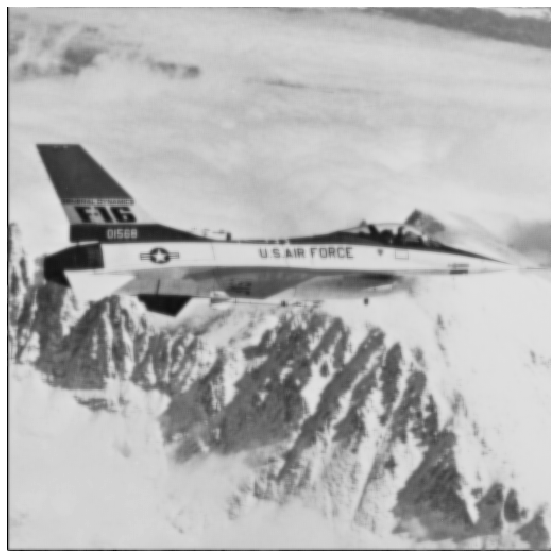

In [9]:
def diffusion_analytic_TV(u, N, epsilon):
    for i in range(N):      
        u_X=np.gradient(u)[1]
        u_Y=np.gradient(u)[0]
        
        varIn = epsilon + u_X**2 + u_Y**2
        varInSqrt = np.sqrt(varIn)

        u_XX = np.gradient(u_X)[1]
        u_YX=np.gradient(u_Y)[1]
        
        u_YY = np.gradient(u_Y)[0]
        u_XY = np.gradient(u_X)[0]

        
       
        vXgX= (u_XX * varInSqrt - u_X * ((u_X*u_XX+ u_Y*u_YX)/varInSqrt))/varIn
        vYgY= (u_YY * varInSqrt - u_Y * ((u_X*u_XY+ u_Y*u_YY)/varInSqrt))/varIn

        divNum = vXgX+vYgY
        u = u + divNum
    return u

new_image = diffusion_analytic_TV(u, 3, 10)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(new_image,vmin=0,vmax=1, cmap='gray')
plt.show()

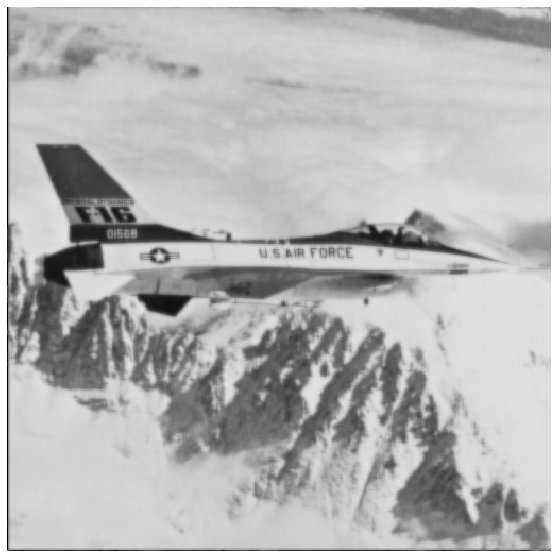

In [36]:
def diffusion_num_TV(u, N):
    for i in range(N):      
        u_X=np.gradient(u)[0]
        u_Y=np.gradient(u)[1]

        norme = np.sqrt(u_X**2 + u_Y**2)
        epsilon = 10    #5

        vX = u_X/(np.sqrt(epsilon+norme**2))
        vY = u_Y/(np.sqrt(epsilon+norme**2))
       
        vXgX=np.gradient(vX)[0]
        vYgY=np.gradient(vY)[1]

        divNum = vXgX+vYgY
        u = u + divNum
    return u

new_image = diffusion_num_TV(u, 3)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(new_image,vmin=0,vmax=1, cmap='gray')
plt.show()

Run regularization experiments and evaluate the quality of the denoising process w.r.t. the main parameters of the regularization scheme

Illustrate through one or two examples the key properties of the diffusion  associated with this TV formulation

For pixels on contour, the corresponding diffusion value will be small, so the infomation of contour will be preserved. 

# Part IV: TV denoising
Implement and benchmark TV denoising schemes, including a comparison to the Laplacian diffusion process.

In [11]:
def denoisingTV(v,N,epsilon,Lambda,alpha):
    u_k = np.copy(v)
    epsilon = epsilon
    pX= np.array([[-1,1],[-1,1]])
    pY= np.array([[-1,-1],[1,1]])
    for i in range(N):
        u_X=np.gradient(u_k)[0]
        u_Y=np.gradient(u_k)[1]
        
        norme = np.sqrt(u_X**2 + u_Y**2)
        vX = u_X/(np.sqrt(epsilon+norme**2))
        vY = u_Y/(np.sqrt(epsilon+norme**2))


        vXgX=np.gradient(vX)[0]
        vYgY=np.gradient(vY)[1]

        u_k = u_k - Lambda*(2*(u_k -v)-alpha * (vXgX+vYgY))
    uf = u_k
    return uf

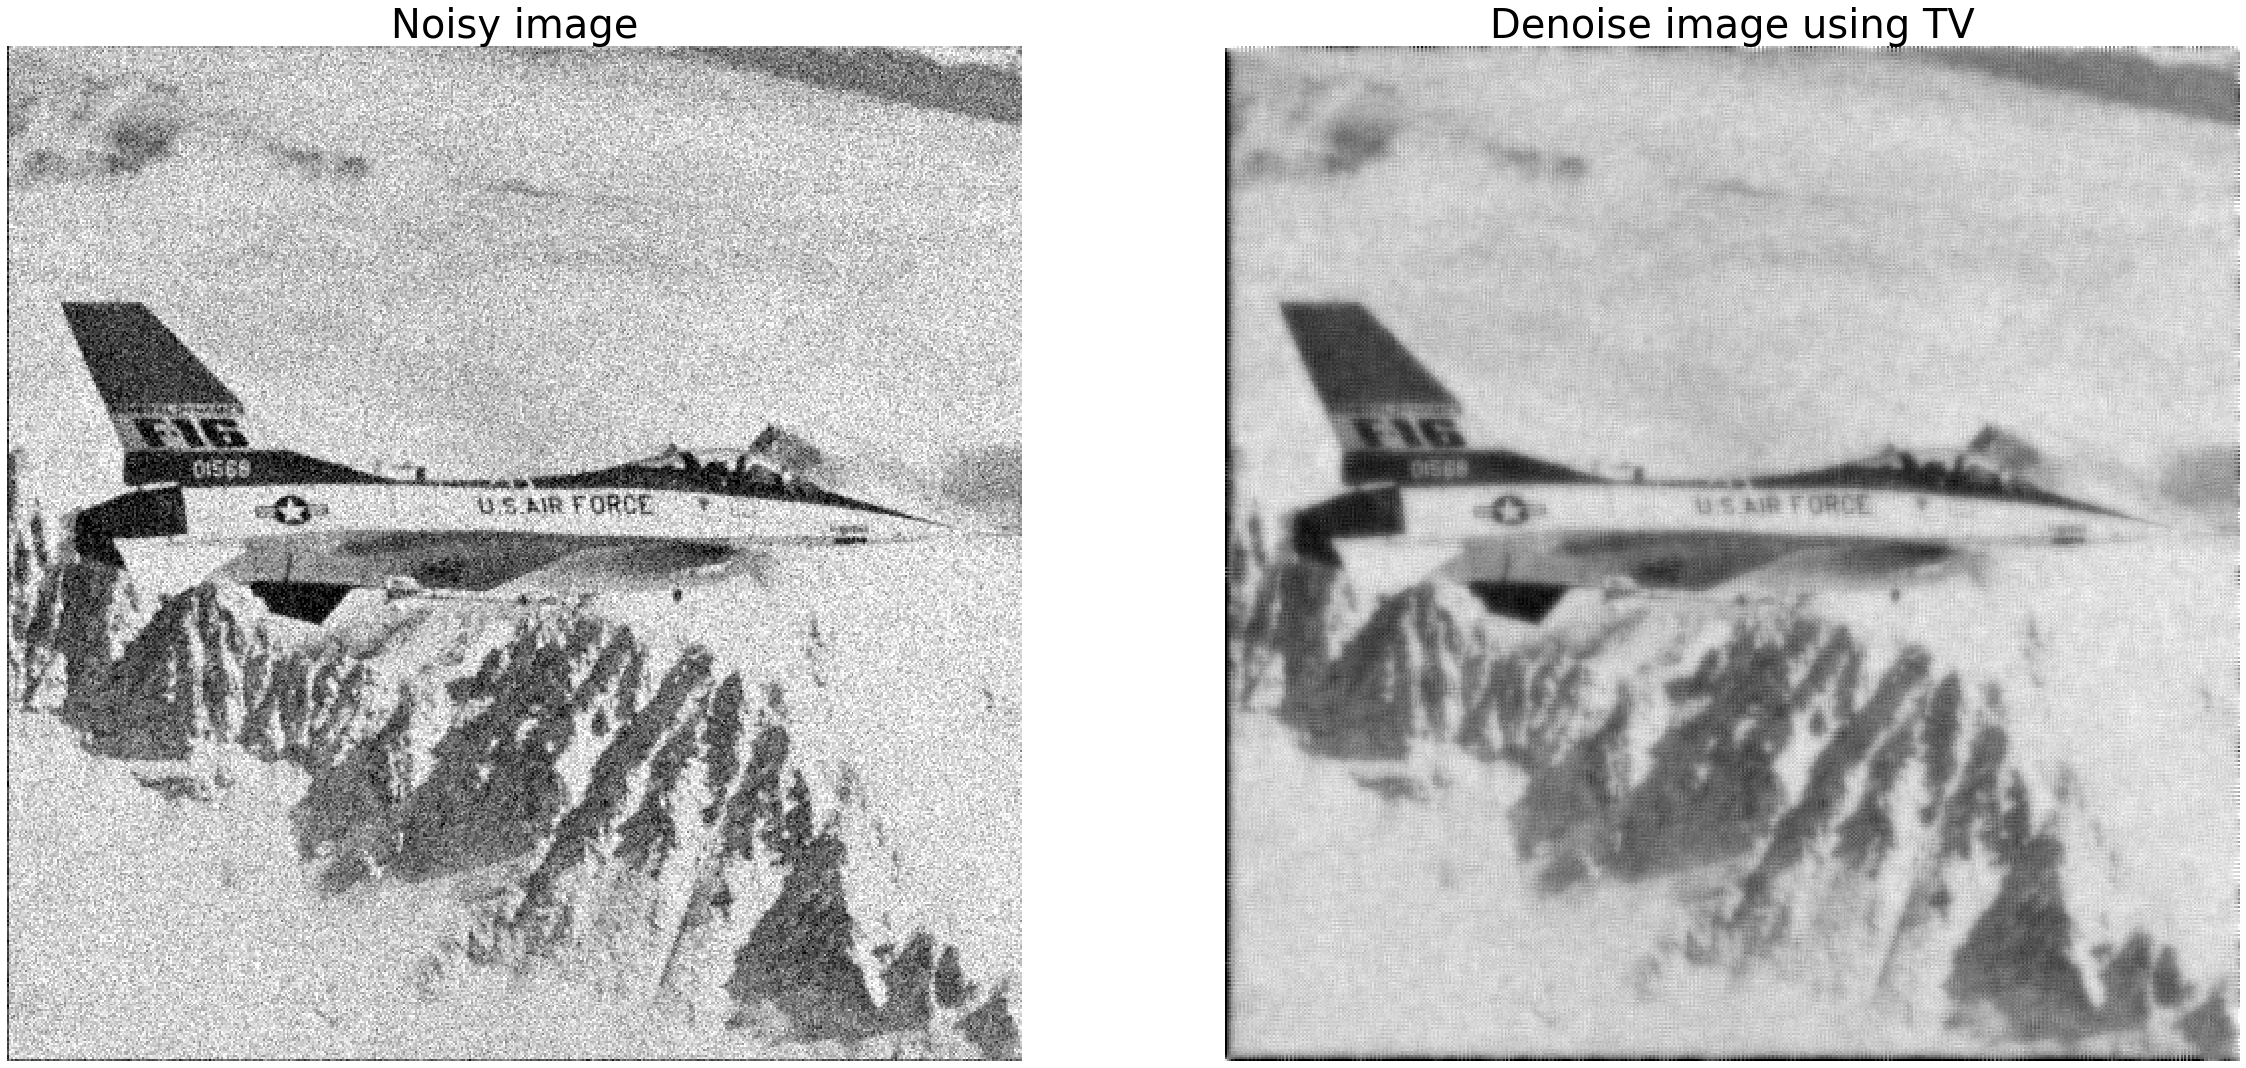

In [12]:
u_denoise_TV = denoisingTV(u_noise, 100, 2, 0.02, 10)  #100 0.4 0.04
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('Noisy image',fontsize=40)
plt.axis('off')
plt.imshow(u_noise,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise image using TV",fontsize=40)
plt.axis('off')
plt.imshow(u_denoise_TV,vmin=0,vmax=1, cmap='gray')
plt.show()

In [13]:
moudle = np.zeros((512, 512))
moudle[206:306, 206:306] = 1 
denoise_moudle = denoisingTV(moudle, 100, 2, 0.02, 10)

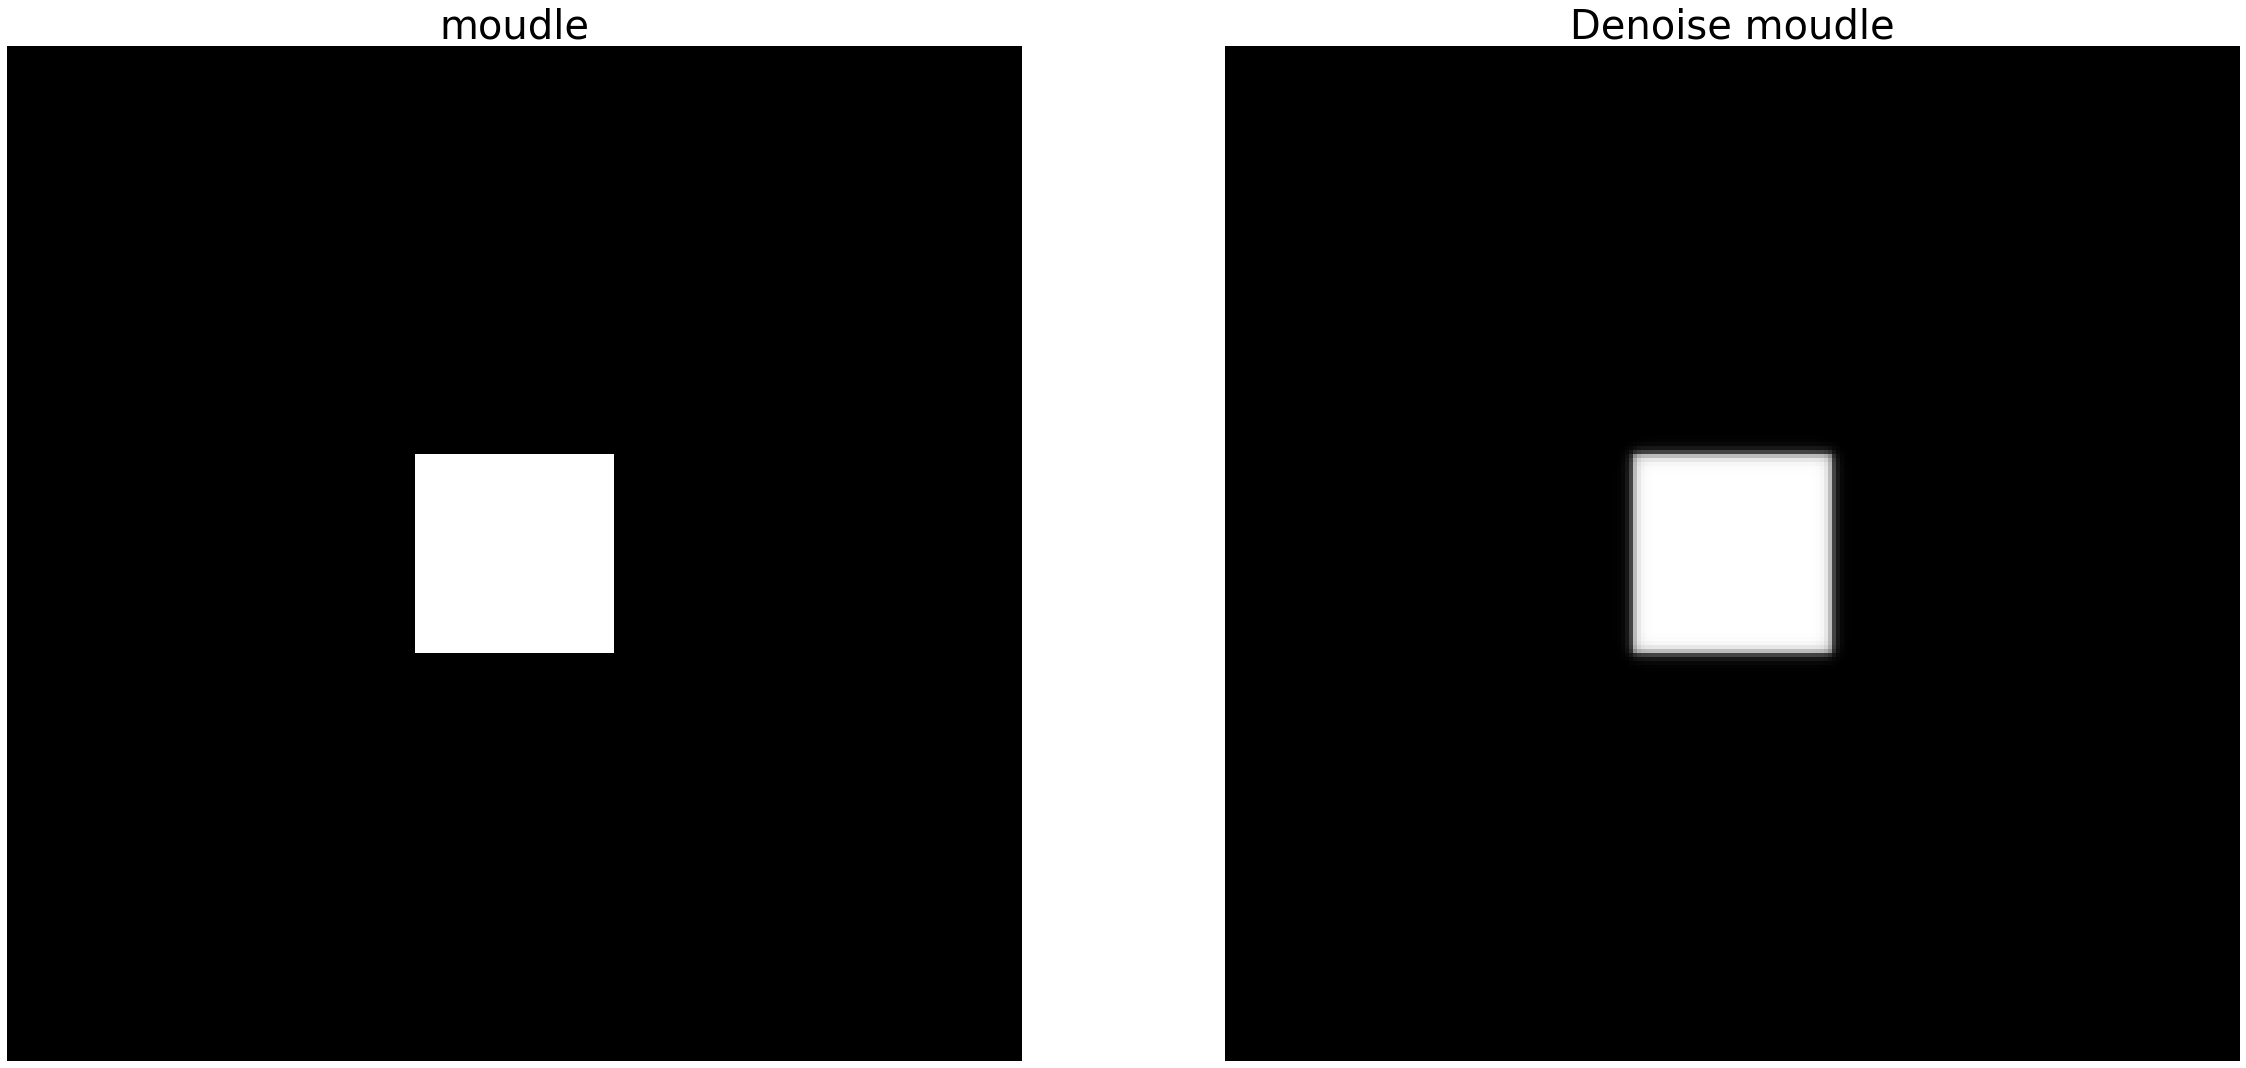

In [14]:
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('moudle', fontsize=40)
plt.axis('off')
plt.imshow(moudle,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise moudle", fontsize=40)
plt.axis('off')
plt.imshow(denoise_moudle,vmin=0,vmax=1, cmap='gray')
plt.show()

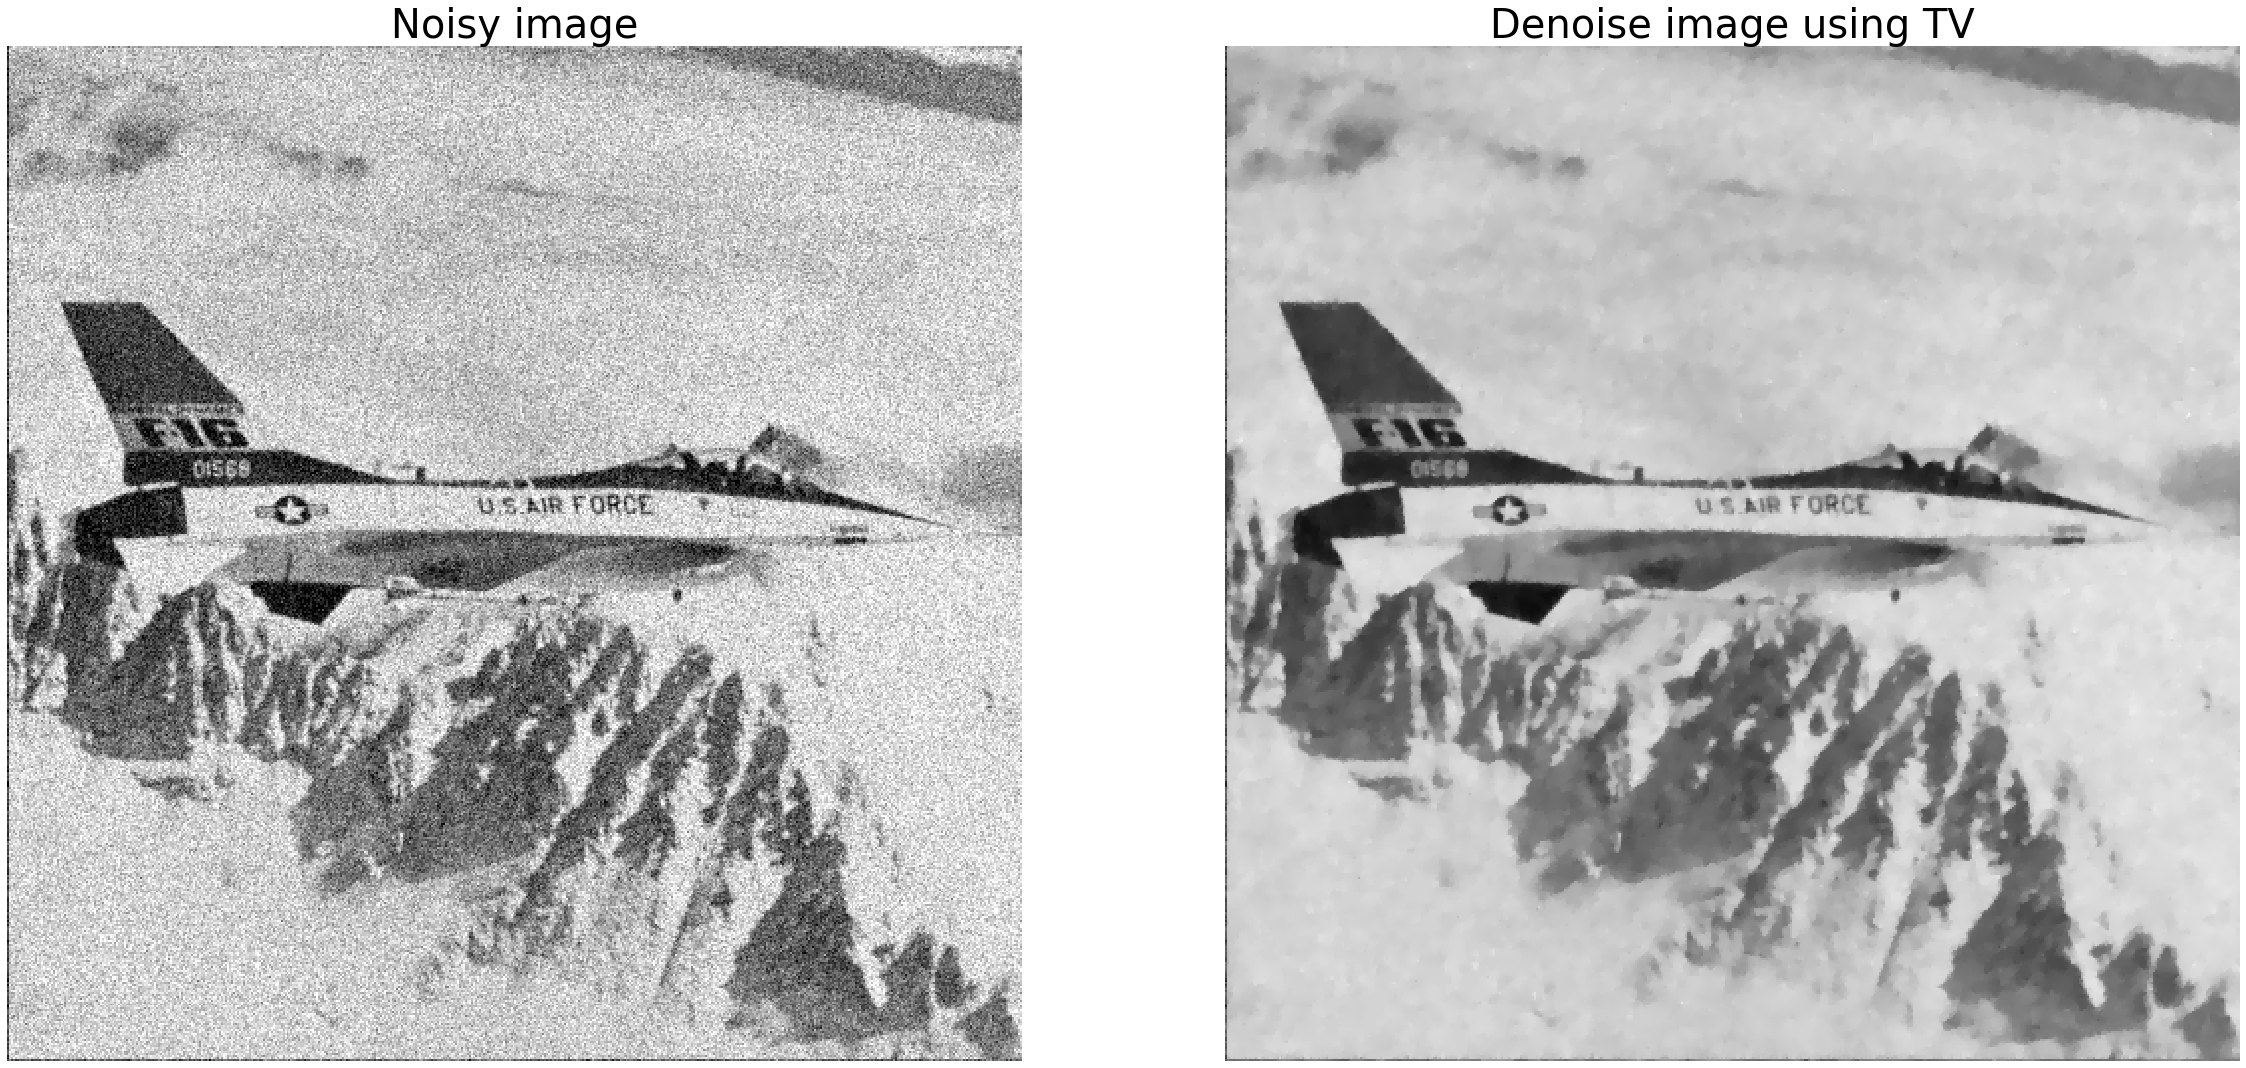

In [15]:
from skimage.restoration import denoise_tv_chambolle
image_triche = denoise_tv_chambolle(u_noise, 0.1)
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('Noisy image',fontsize=40)
plt.axis('off')
plt.imshow(u_noise,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise image using TV",fontsize=40)
plt.axis('off')
plt.imshow(image_triche,vmin=0,vmax=1, cmap='gray')
plt.show()

In [16]:
moudle = np.zeros((512, 512))
moudle[206:306, 206:306] = 1 
denoise_moudle = denoise_tv_chambolle(moudle, 0.1)

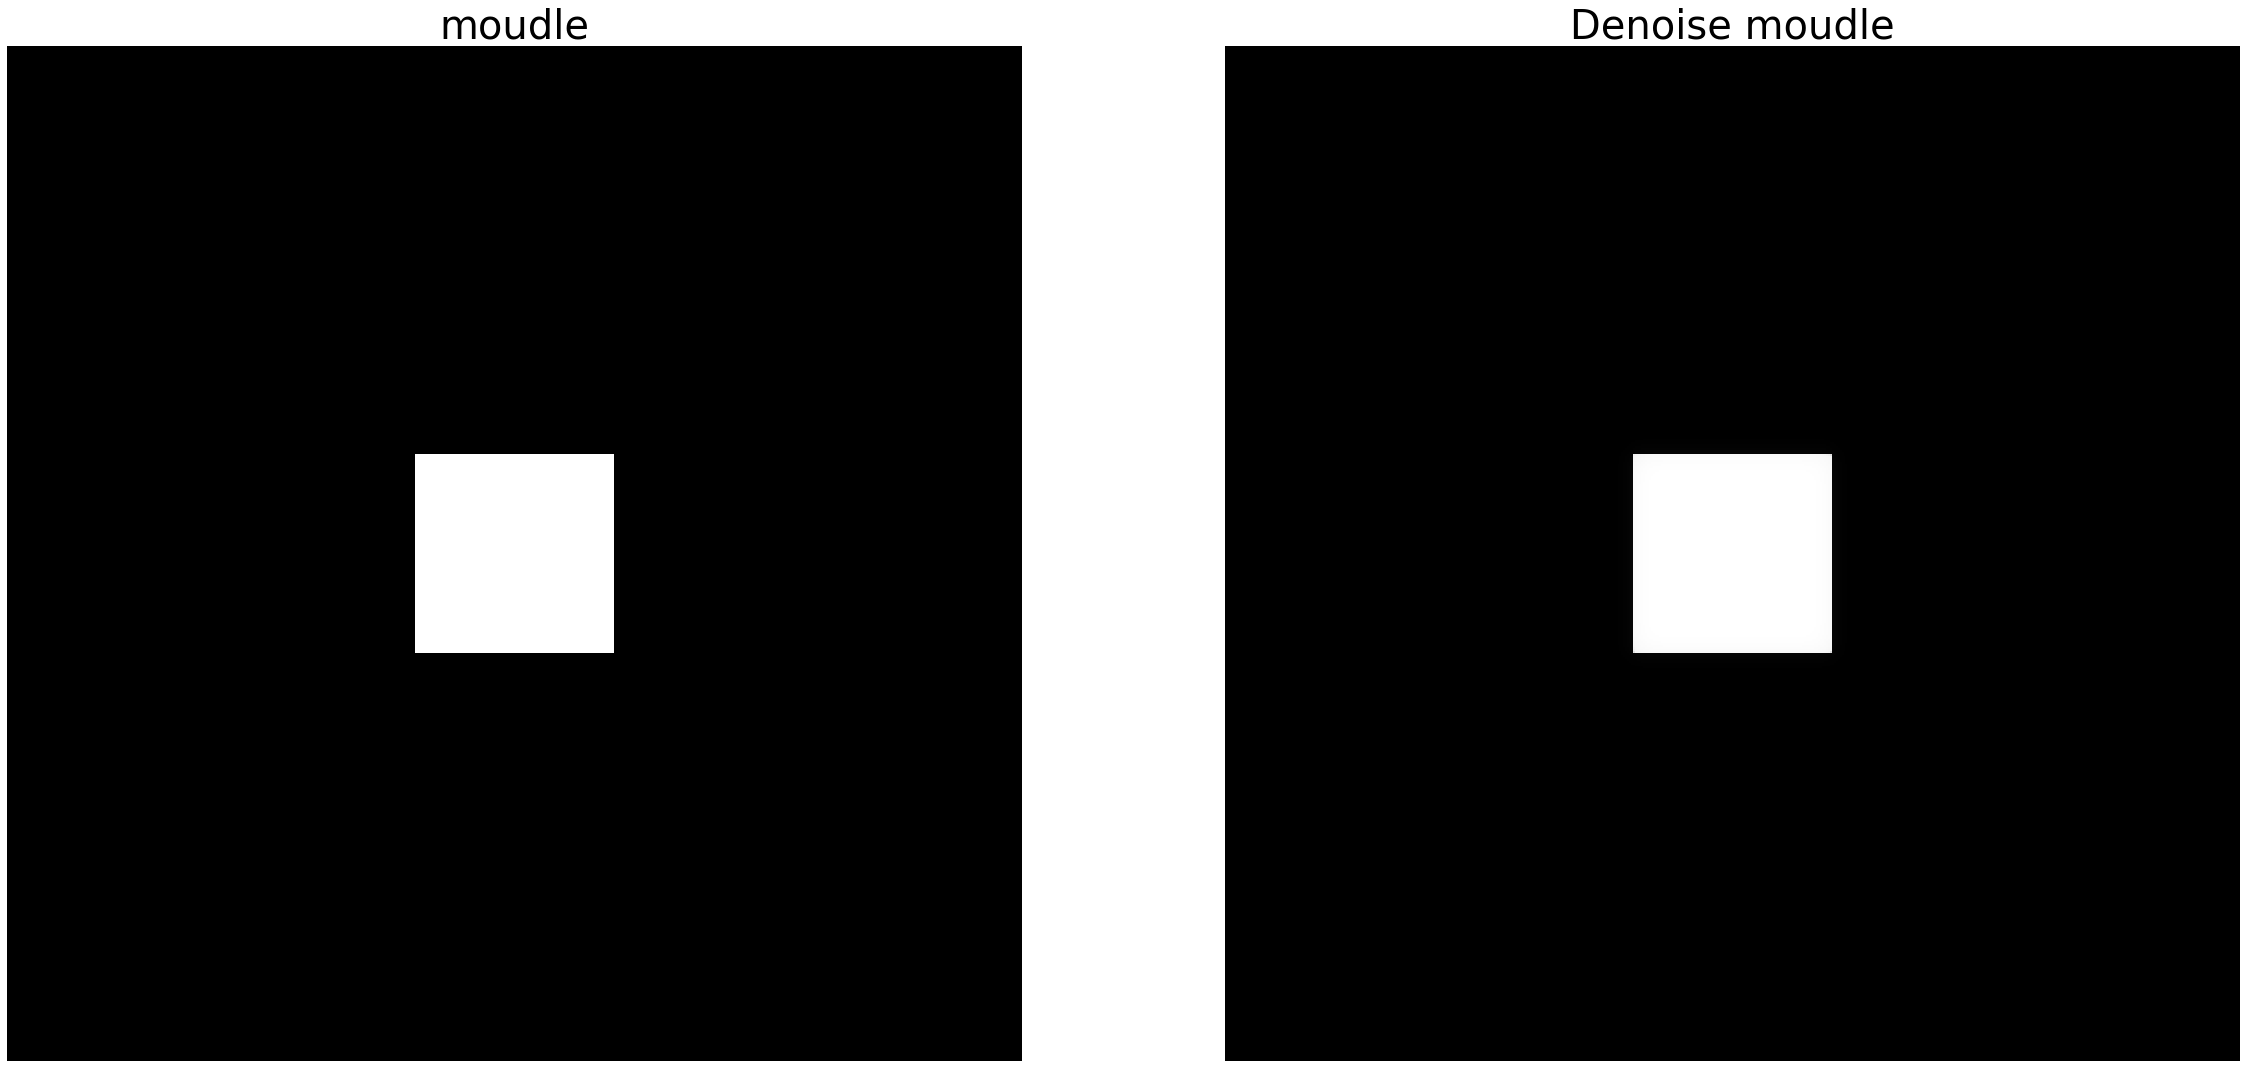

In [17]:
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('moudle', fontsize=40)
plt.axis('off')
plt.imshow(moudle,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise moudle", fontsize=40)
plt.axis('off')
plt.imshow(denoise_moudle,vmin=0,vmax=1, cmap='gray')
plt.show()

Illustrate through one or two examples the key properties of the diffusion  associated with the TV denoising

##response:
-The diffusion associated with TV denoising is anisotropic, for pixels on contour, the observation term play a more important role than the regulization term, so the contours can be well preserved.

# Part V: Perona-Malik diffusion (Bonus)
Implement and benchmark diffusion schemes defined as:
$$ \frac{\partial u}{\partial t}= div \left ( c(\|\nabla u(p)\| )  \nabla u(p) \right )$$
with different choices for function $c()$: $c(x)=1-exp(-x^2/K^2)$, $c(x)=\left [1+x^2/K^2\right]^{-1/2}$, $c(x)=\left [1+x^2/K^2\right]^{-1}$.

In [18]:
def diffusion_TV(u, N, K, c_type):
    for i in range(N):      
        u_X=np.gradient(u)[0]
        u_Y=np.gradient(u)[1]

        norme = np.sqrt(u_X**2 + u_Y**2)
        if c_type == 1:
            c= 1 - np.exp(-norme**2/K**2)
        elif c_type == 2:
            c= 1/np.sqrt(1 + norme**2/K**2)
        else:
            c= 1/(1 + norme**2/K**2)
            
            
        vX = u_X*c
        vY = u_Y*c
       
        vXgX=np.gradient(vX)[0]
        vYgY=np.gradient(vY)[1]

        divNum = vXgX+vYgY
        u = u + divNum
    return u

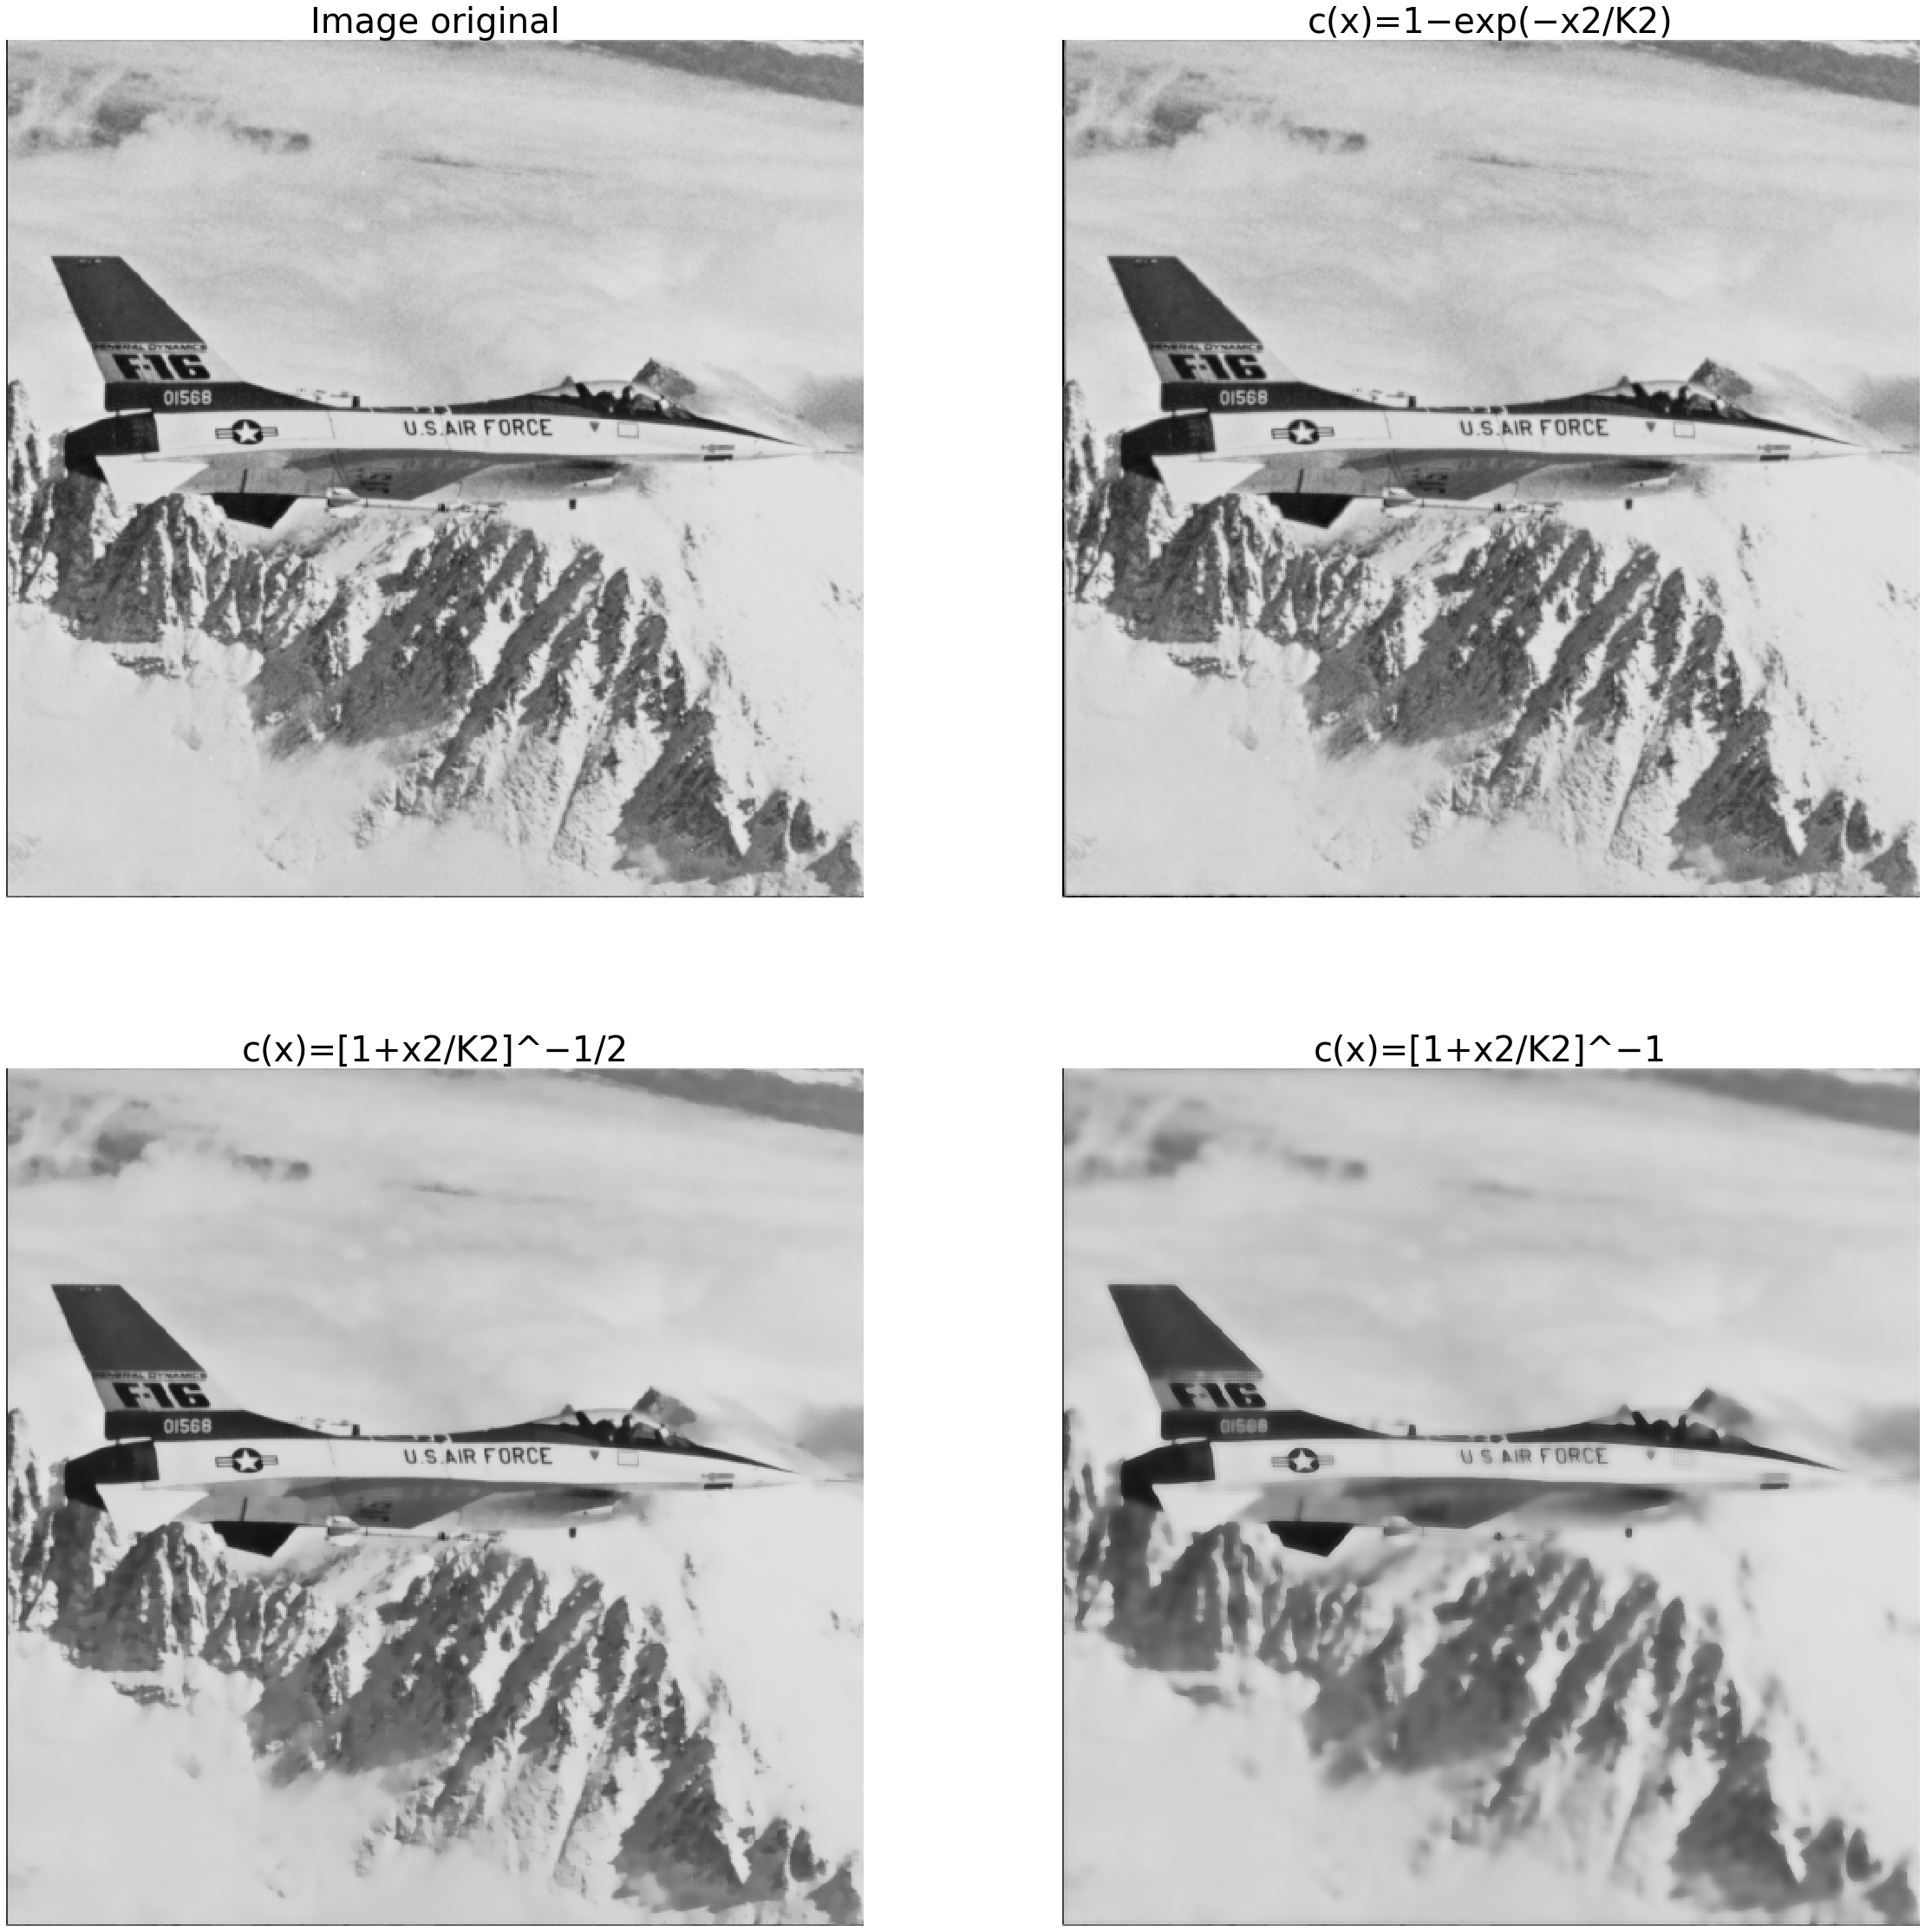

In [19]:
image_1 = diffusion_TV(u, 3, 1, 1)
image_2 = diffusion_TV(u, 3, 0.01, 2)
image_3 = diffusion_TV(u, 3, 0.1, 3)


plt.figure(figsize=(40,40))
plt.subplot(221)
plt.title('Image original',fontsize=40)
plt.axis('off')
plt.imshow(u,vmin=0,vmax=1, cmap='gray')


plt.subplot(222)
plt.title("c(x)=1−exp(−x2/K2)",fontsize=40)
plt.axis('off')
plt.imshow(image_1,vmin=0,vmax=1, cmap='gray')

plt.subplot(223)
plt.title('c(x)=[1+x2/K2]^−1/2',fontsize=40)
plt.axis('off')
plt.imshow(image_2,vmin=0,vmax=1, cmap='gray')


plt.subplot(224)
plt.title("c(x)=[1+x2/K2]^−1",fontsize=40)
plt.axis('off')
plt.imshow(image_3,vmin=0,vmax=1, cmap='gray')
plt.show()

# Part VI: MRF-based image denoising
This section aims to implement and test Markov Random Field (MRF) algorithms for image denoising. Based on discretized version of variational energy:
$$ \int_\Omega \| u(p)-v(p)\|^2dp+\alpha \int_\Omega \|\nabla u(p)\|^2dp$$,
derive the observation lieklihood model $P(V|U)$ and the Markovian prior $P(U)$ of the associated MRF formulation. 
Derive an iterative denoising algorithm based on the maximization of the following posterior likelihood: $$P(U_p|V,U_q, \ q \neq p )$$
Implement this algorithm and compare to the Laplacian diffusion process.

In [20]:
def compute_log_prob_helper(Y, i, j):
    try:
        return Y[i][j]
    except IndexError:
        return 0

In [21]:
def compute_prob(u, i, j):
    
    result = (u[i][j] - compute_log_prob_helper(u, i-1, j))
    result += (u[i][j] - compute_log_prob_helper(u, i+1, j))
    result +=  (u[i][j] - compute_log_prob_helper(u, i, j-1))
    result +=  (u[i][j] - compute_log_prob_helper(u, i, j+1))
    return result

In [22]:
def gradient(u,v,beta):     
    m, n = np.shape(v)
    # initialize Y same as X
    u_copy = np.copy(u)
    for i in range(m):
        for j in range(n):
            u_copy[i][j] = 2*beta*compute_prob(u, i, j)
    gradient = u_copy  + 2*(u-v)
    return gradient  

In [23]:
def denoise_RMF(v, N, lambda_, beta):
    u = np.copy(v)
    for i in range(N):
        u = u - lambda_*gradient(u, v, beta)
    return u

In [24]:
denoise_image_RMF = denoise_RMF(u_noise, 50, 0.01, 3)

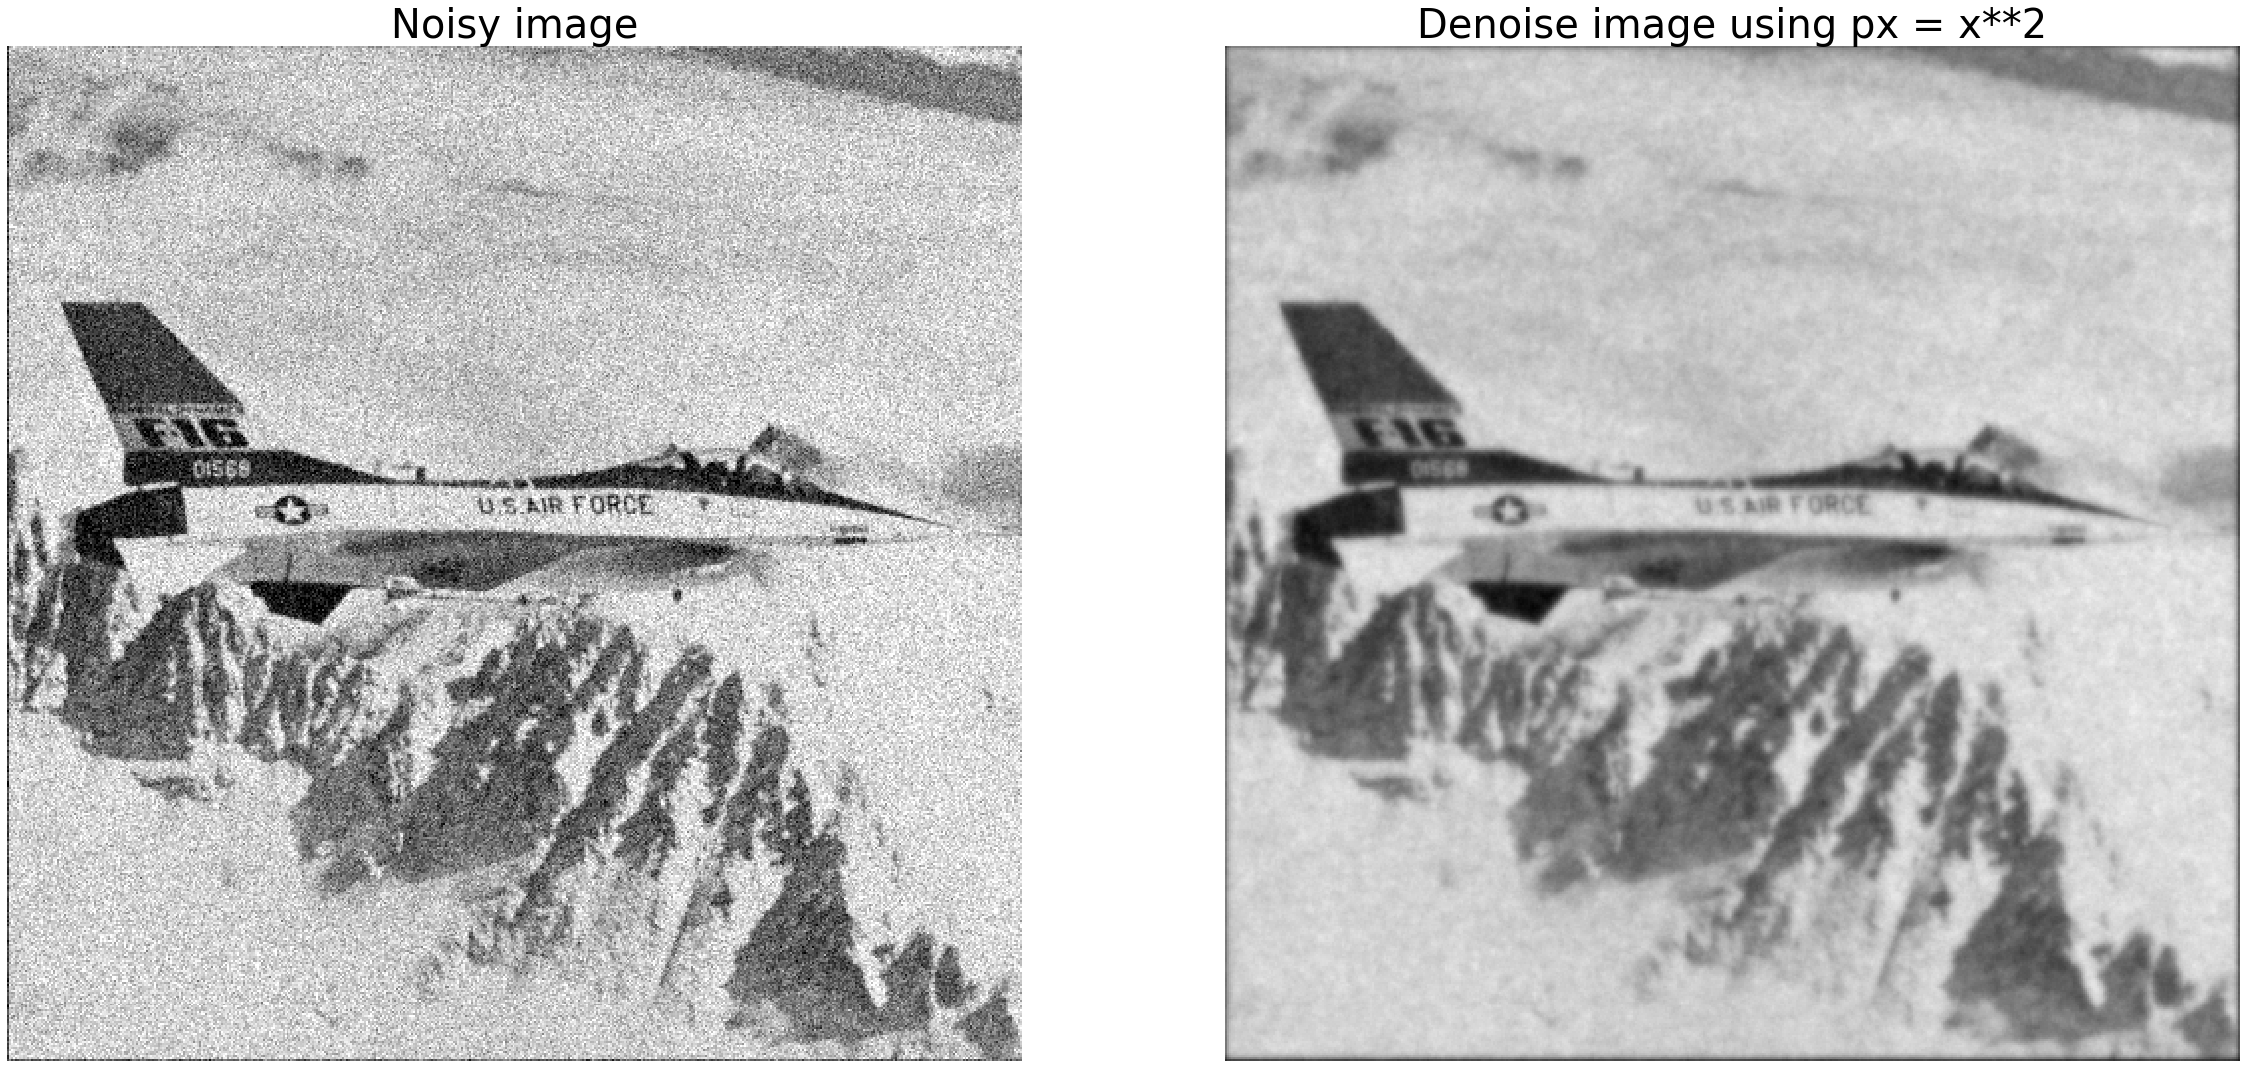

In [25]:
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('Noisy image',fontsize=40)
plt.axis('off')
plt.imshow(u_noise,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise image using px = x**2",fontsize=40)
plt.axis('off')
plt.imshow(denoise_image_RMF,vmin=0,vmax=1, cmap='gray')
plt.show()

In [26]:
moudle = np.zeros((512, 512))
moudle[206:306, 206:306] = 1 
denoise_moudle = denoise_RMF(moudle, 50, 0.01, 3)

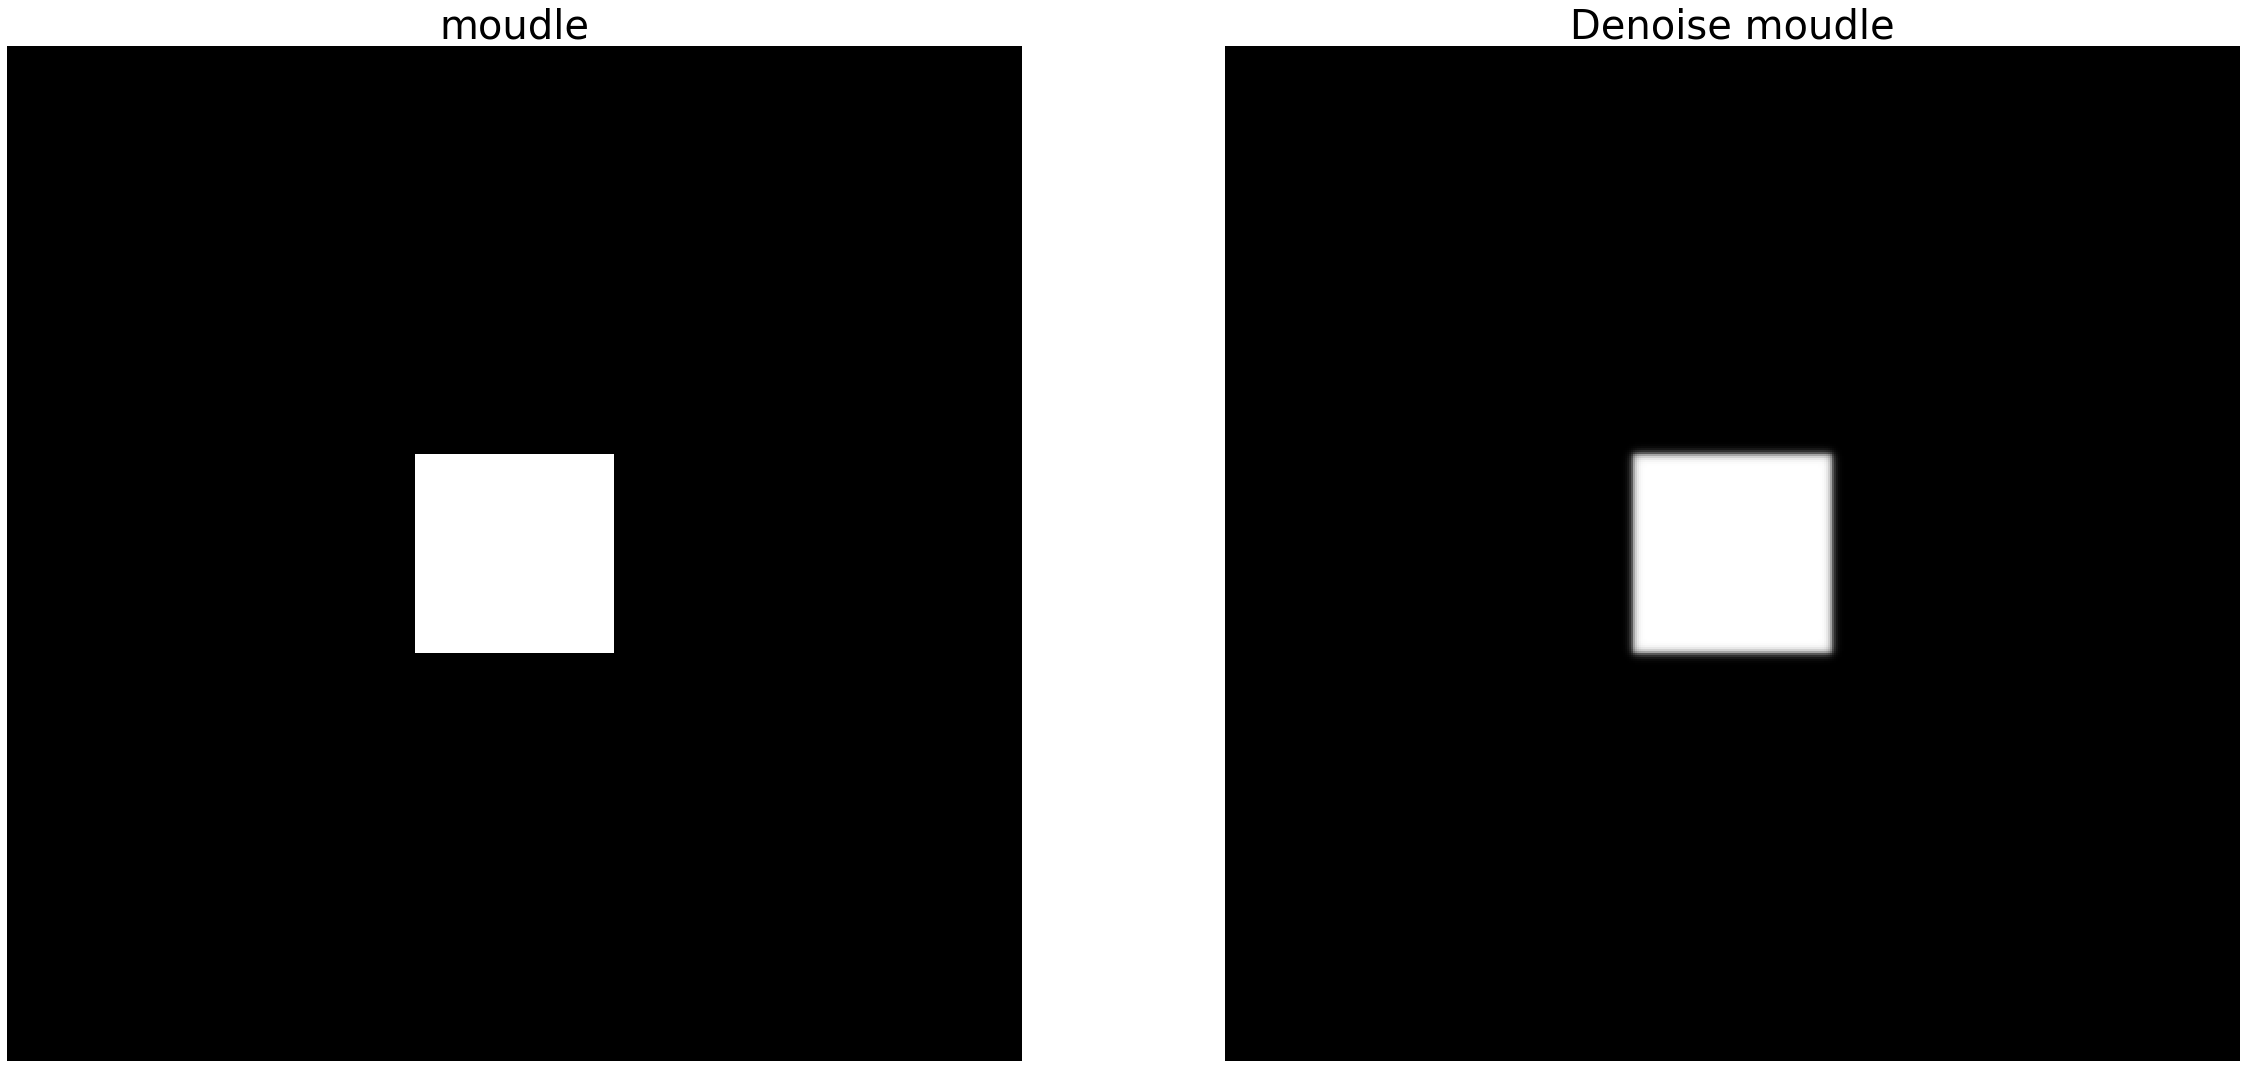

In [27]:
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('moudle',fontsize=40)
plt.axis('off')
plt.imshow(moudle,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise moudle",fontsize=40)
plt.axis('off')
plt.imshow(denoise_moudle,vmin=0,vmax=1, cmap='gray')
plt.show()

In [28]:
def compute_prob_2(u, i, j,epsilon):
    
    result = (u[i][j] - compute_log_prob_helper(u, i-1, j))/np.sqrt(epsilon + np.square(u[i][j] - compute_log_prob_helper(u, i-1, j)))
    result += (u[i][j] - compute_log_prob_helper(u, i+1, j))/np.sqrt(epsilon + np.square(u[i][j] - compute_log_prob_helper(u, i+1, j)))
    result +=  (u[i][j] - compute_log_prob_helper(u, i, j-1))/np.sqrt(epsilon + np.square(u[i][j] - compute_log_prob_helper(u, i, j-1)))
    result +=  (u[i][j] - compute_log_prob_helper(u, i, j+1))/np.sqrt(epsilon + np.square(u[i][j] - compute_log_prob_helper(u, i, j+1)))
    return result

In [29]:
def gradient_2(u, v, beta, epsilon):     
    m, n = np.shape(v)
    # initialize Y same as X
    u_copy = np.copy(u)
    for i in range(m):
        for j in range(n):
            u_copy[i][j] = 2*beta*compute_prob_2(u, i, j, epsilon)
    gradient = u_copy  + 2*(u-v)
    return gradient 

In [30]:
def denoise_RMF_2(v, N, lambda_, beta, epsilon):
    u = np.copy(v)
    for i in range(N):
        u = u - lambda_*gradient_2(u, v, beta, epsilon)
    return u

In [31]:
denoise_image_RMF_2 = denoise_RMF_2(u_noise, 60, 0.01, 3, 5) #60, 0.01, 3, 0.1

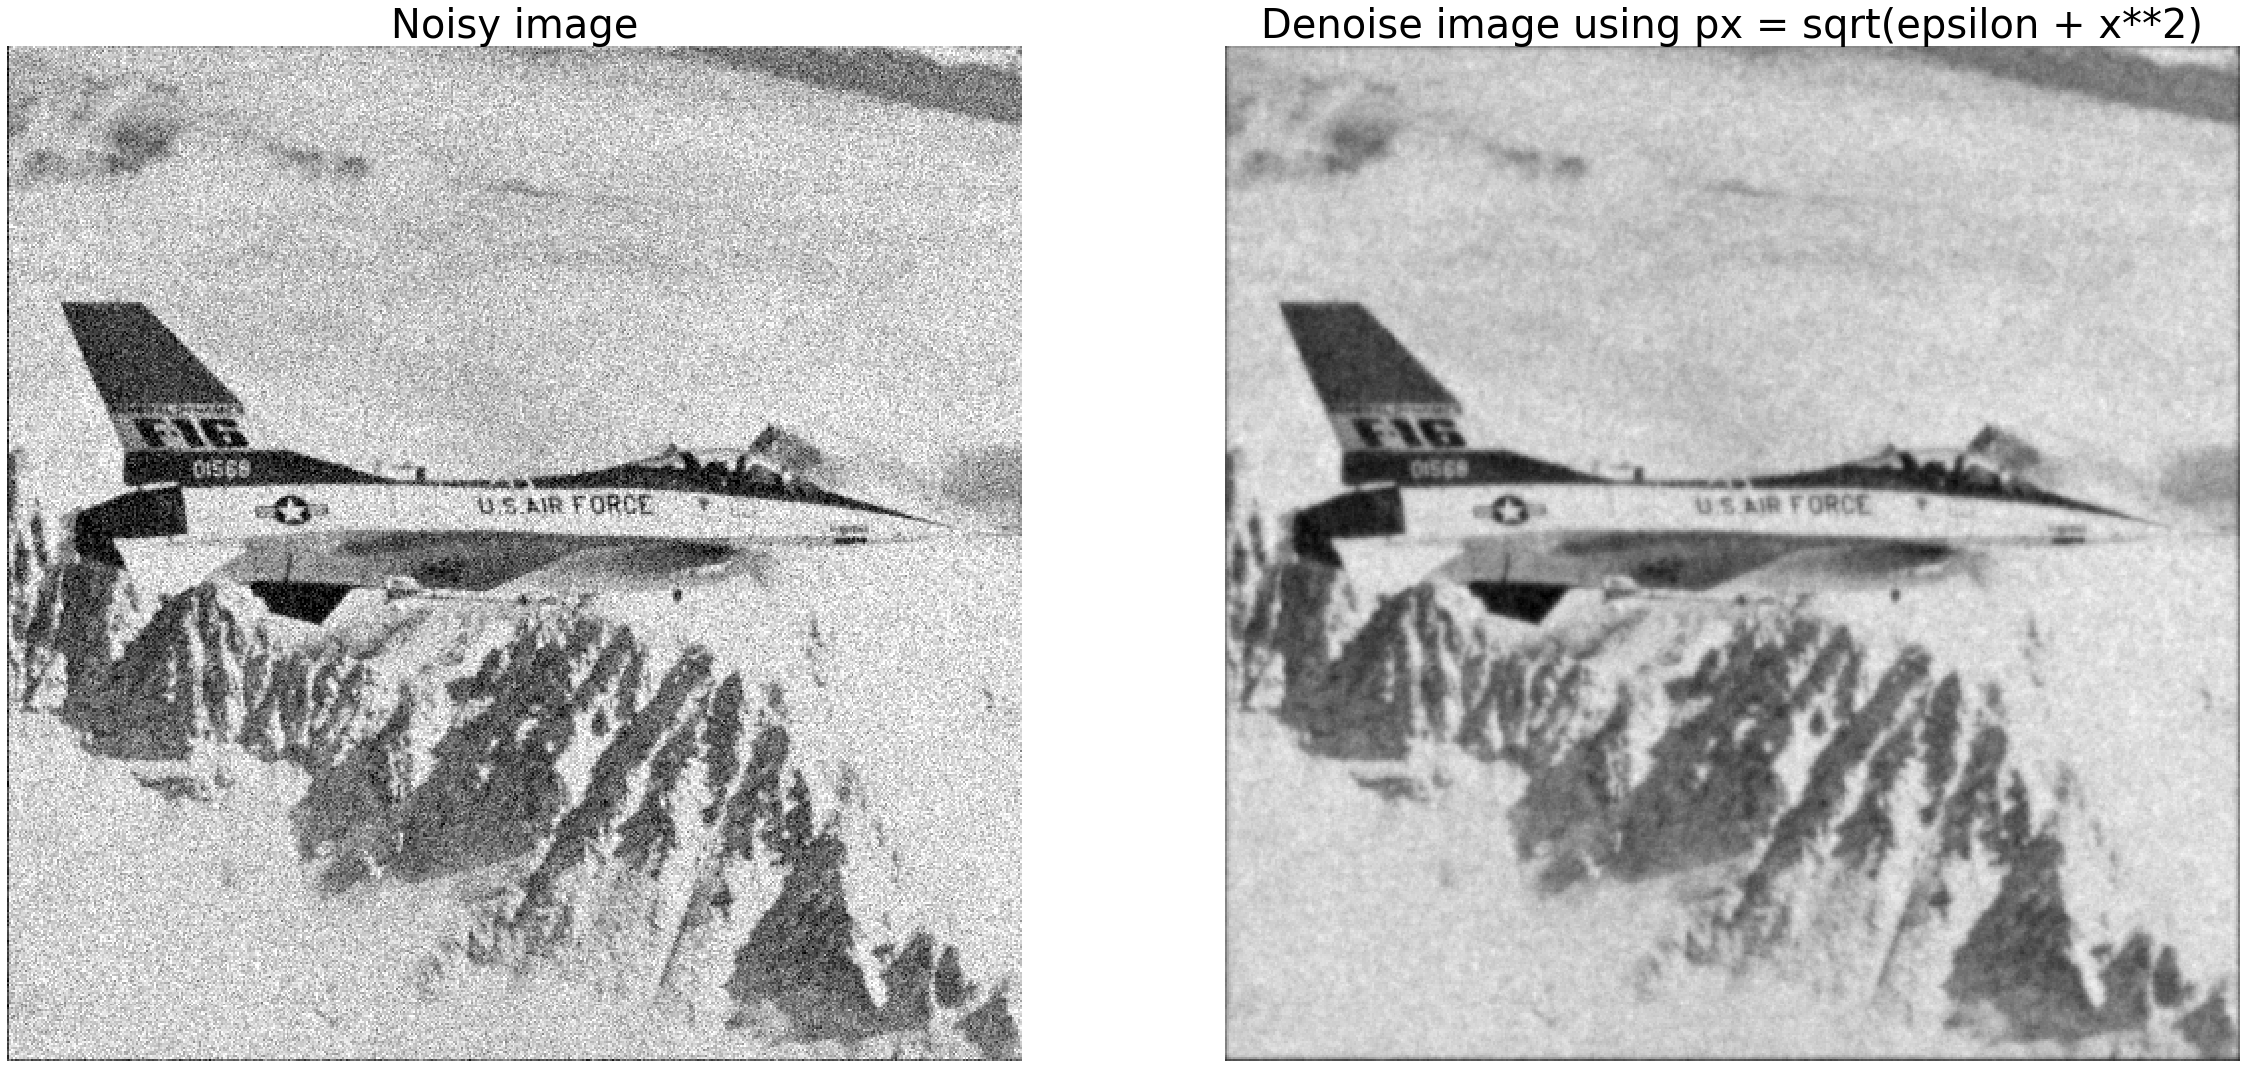

In [32]:
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('Noisy image',fontsize=40)
plt.axis('off')
plt.imshow(u_noise,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise image using px = sqrt(epsilon + x**2)",fontsize=40)
plt.axis('off')
plt.imshow(denoise_image_RMF_2,vmin=0,vmax=1, cmap='gray')
plt.show()

In [33]:
moudle = np.zeros((512, 512))
moudle[206:306, 206:306] = 1 
denoise_moudle = denoise_RMF_2(moudle, 60, 0.01, 3, 4)

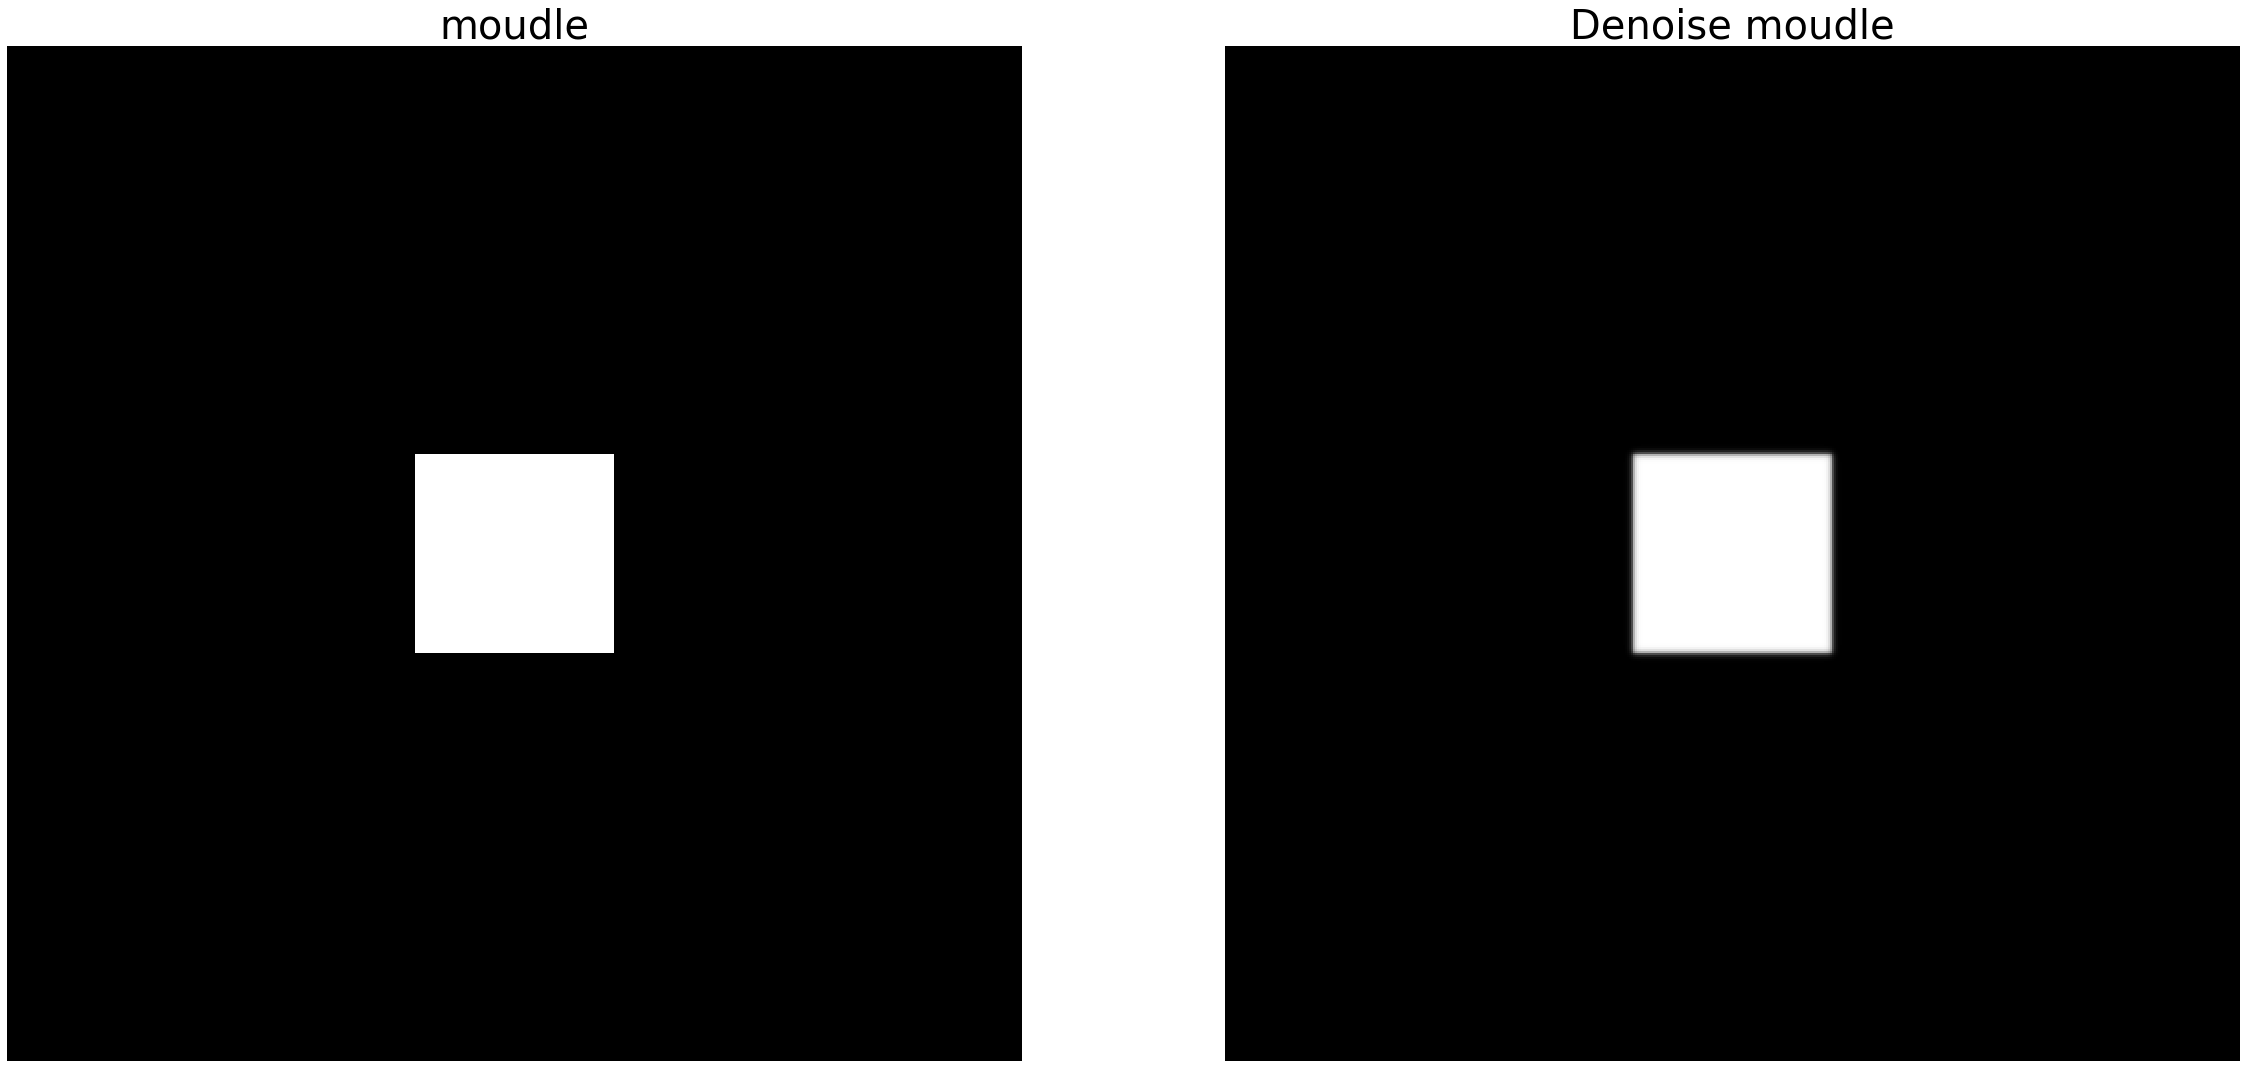

In [34]:
plt.figure(figsize=(40,20))
plt.subplot(121)
plt.title('moudle',fontsize=40)
plt.axis('off')
plt.imshow(moudle,vmin=0,vmax=1, cmap='gray')


plt.subplot(122)
plt.title("Denoise moudle",fontsize=40)
plt.axis('off')
plt.imshow(denoise_moudle,vmin=0,vmax=1, cmap='gray')
plt.show()

Bonus: Using a m-estimator instead of the quadratic prior (cf. https://hal.inria.fr/inria-00350297/document) and an reweigthed iterative least-square algorithm, implement a generalization of the above MRF formulation which accounts for a more appropriate prior than a Gaussian prior.